# [Product Recommendations for Online Retail Store](https://medium.com/@peggy1502/product-recommendations-for-online-retail-store-1d565e1607b7)
### Build and Train a Personalized Recommender Engine with Amazon Sagemaker Factorization Machines

**This is `Notebook Part 1`**

**Click [here](fm_v3_part2.ipynb) for `Notebook Part 2`**

In [1]:
import numpy as np 
import pandas as pd 
import time

import boto3
#import sagemaker
#import sagemaker.amazon.common as smac

from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

numpy version: 1.19.5
pandas version: 1.3.3


# Read Dataset

In [3]:
pd.set_option('display.max_columns', 50)

df = pd.read_csv("../input/pakistans-largest-ecommerce-dataset/Pakistan Largest Ecommerce Dataset.csv", 
                 parse_dates=["created_at", "Working Date"], low_memory=False)
df

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,discount_amount,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,211131.0,complete,2016-07-01,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,\N,0.0,cod,2016-07-01,#REF!,"1,950",2016.0,7.0,2016-7,7-2016,FY17,1.0,NaN,NaN,NaN,NaN,NaN
1,211133.0,canceled,2016-07-01,kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...,240.0,1.0,240.0,100147444,Beauty & Grooming,\N,0.0,cod,2016-07-01,Gross,240,2016.0,7.0,2016-7,7-2016,FY17,2.0,NaN,NaN,NaN,NaN,NaN
2,211134.0,canceled,2016-07-01,Ego_UP0017-999-MR0,2450.0,1.0,2450.0,100147445,Women's Fashion,\N,0.0,cod,2016-07-01,Gross,"2,450",2016.0,7.0,2016-7,7-2016,FY17,3.0,NaN,NaN,NaN,NaN,NaN
3,211135.0,complete,2016-07-01,kcc_krone deal,360.0,1.0,60.0,100147446,Beauty & Grooming,R-FSD-52352,300.0,cod,2016-07-01,Net,360,2016.0,7.0,2016-7,7-2016,FY17,4.0,NaN,NaN,NaN,NaN,NaN
4,211136.0,order_refunded,2016-07-01,BK7010400AG,555.0,2.0,1110.0,100147447,Soghaat,\N,0.0,cod,2016-07-01,Valid,"1,110",2016.0,7.0,2016-7,7-2016,FY17,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

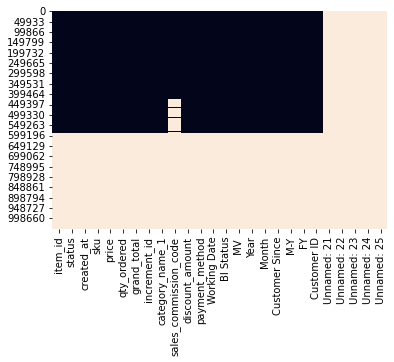

In [4]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)

In [5]:
columns = ["sku", "category_name_1", "Customer ID", "price", "qty_ordered"]
df = df[columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sku              584504 non-null  object 
 1   category_name_1  584360 non-null  object 
 2   Customer ID      584513 non-null  float64
 3   price            584524 non-null  float64
 4   qty_ordered      584524 non-null  float64
dtypes: float64(3), object(2)
memory usage: 40.0+ MB


# Data Cleaning

### (i) Drop empty rows & columns, and handle missing values

In [7]:
df = df.dropna(how="all", axis=0) # Drop empty rows
df = df.dropna(how="all", axis=1) # Drop empty columns

In [8]:
df.isna().sum()

sku                 20
category_name_1    164
Customer ID         11
price                0
qty_ordered          0
dtype: int64

In [9]:
# Drop rows where sku or Customer ID is null.

df.dropna(axis=0, subset=["sku", "Customer ID"], inplace=True) 

In [10]:
# Replace missing value for category_name_1 with empty string.

df["category_name_1"].fillna("", inplace=True)

In [11]:
df.isna().sum()

sku                0
category_name_1    0
Customer ID        0
price              0
qty_ordered        0
dtype: int64

In [12]:
df

,sku,category_name_1,Customer ID,price,qty_ordered
0,kreations_YI 06-L,Women's Fashion,1.0,1950.0,1.0
1,kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...,Beauty & Grooming,2.0,240.0,1.0
2,Ego_UP0017-999-MR0,Women's Fashion,3.0,2450.0,1.0
3,kcc_krone deal,Beauty & Grooming,4.0,360.0,1.0
4,BK7010400AG,Soghaat,5.0,555.0,2.0
...,...,...,...,...,...
584519,WOFSCE5AE00357AECDE,Women's Fashion,115320.0,699.0,1.0
584520,MATHUA5AF70A7D1E50A,Mobiles & Tablets,115326.0,35599.0,1.0
584521,MATSAM5B6D7208C6D30,Mobiles & Tablets,113474.0,129999.0,2.0
584522,MATSAM5B1509B4696EA,Mobiles & Tablets,113474.0,87300.0,2.0


### (ii) Remove leading and trailing spaces for `sku` and `category_name_1`

In [13]:
df["sku"] = df["sku"].apply(lambda x: x.strip())

In [14]:
df[["sku", "category_name_1"]] = df[["sku", "category_name_1"]
                                   ].apply(lambda x: x.str.strip())

In [15]:
# To check that leading space has been removed.
# E.g. the original sku "" Huawei Mate 8" has a leading space.
df[df["sku"] == "Huawei Mate 8"].head(2)

,sku,category_name_1,Customer ID,price,qty_ordered
19328,Huawei Mate 8,Mobiles & Tablets,5191.0,54999.0,1.0
19332,Huawei Mate 8,Mobiles & Tablets,5191.0,54999.0,1.0


### (iii) For `category_name_1`, replace `\N` with the correct value.

In [16]:
# There are around 7.8K records with "category_name_1" = "\N".

df["category_name_1"].value_counts()

Mobiles & Tablets     115710
Men's Fashion          92219
Women's Fashion        59720
Appliances             52413
Superstore             43613
Beauty & Grooming      41494
Soghaat                34011
Others                 29212
Home & Living          26504
Entertainment          26323
Health & Sports        17502
Kids & Baby            16494
Computing              15933
\N                      7833
School & Education      3478
Books                   1870
                         164
Name: category_name_1, dtype: int64

In [17]:
# Example: For this particular sku, the category_name_1 contains value "\N" and "Superstore".

df[df["sku"]=="RB_Dettol Germ Busting Kit-bf"][["sku", "category_name_1"]]

,sku,category_name_1
57592,RB_Dettol Germ Busting Kit-bf,\N
57593,RB_Dettol Germ Busting Kit-bf,\N
57613,RB_Dettol Germ Busting Kit-bf,\N
57619,RB_Dettol Germ Busting Kit-bf,\N
57634,RB_Dettol Germ Busting Kit-bf,\N
...,...,...
294009,RB_Dettol Germ Busting Kit-bf,Superstore
294269,RB_Dettol Germ Busting Kit-bf,Superstore
295565,RB_Dettol Germ Busting Kit-bf,Superstore
298441,RB_Dettol Germ Busting Kit-bf,Superstore


In [18]:
dfmap = df.copy()

# Select all records where category_name_1 is not "\N".
dfmap = dfmap.loc[dfmap["category_name_1"] != "\\N"]

# Filter only columns "sku", "category_name_1".
dfmap = dfmap[["sku", "category_name_1"]]
dfmap

,sku,category_name_1
0,kreations_YI 06-L,Women's Fashion
1,kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...,Beauty & Grooming
2,Ego_UP0017-999-MR0,Women's Fashion
3,kcc_krone deal,Beauty & Grooming
4,BK7010400AG,Soghaat
...,...,...
584519,WOFSCE5AE00357AECDE,Women's Fashion
584520,MATHUA5AF70A7D1E50A,Mobiles & Tablets
584521,MATSAM5B6D7208C6D30,Mobiles & Tablets
584522,MATSAM5B1509B4696EA,Mobiles & Tablets


In [19]:
# Number of unique sku where category_name_1 is not "\N".
dfmap["sku"].nunique()

84528

In [20]:
# Create a mapping dictionary of sku:category_name_1

dic = dfmap.set_index('sku').to_dict("dict")
dic = dic['category_name_1']
dic

{'kreations_YI 06-L': "Women's Fashion",
 'kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Body Spray Free': 'Beauty & Grooming',
 'Ego_UP0017-999-MR0': "Women's Fashion",
 'kcc_krone deal': 'Beauty & Grooming',
 'BK7010400AG': 'Soghaat',
 'UK_Namkino All In One 200 Gms': 'Soghaat',
 'UK_Namkino Mix Nimco 400 Gms': 'Soghaat',
 'Apple iPhone 6S 64GB': 'Mobiles & Tablets',
 'GFC_Pedestal Myga Cross Base (Special Guard) 24"': 'Appliances',
 'BK1070200PL': 'Soghaat',
 'BK1130200CF': 'Soghaat',
 'kcc_Sultanat': 'Home & Living',
 'kcc_glamour deal': 'Beauty & Grooming',
 'Assetmen_MD-346-M': "Men's Fashion",
 'cr_DATES WITH CASHEW-400 GM': 'Soghaat',
 'UK_Gift Box Mix Dry Fruit Sweets 500 Gms': 'Soghaat',
 'itter_AB 1199': 'Beauty & Grooming',
 'RL_B005': 'Home & Living',
 'bed&rest_S7': 'Home & Living',
 'L&L_LLHLE8224S': 'Home & Living',
 'J&J_JJR-4': 'Kids & Baby',
 'J&J_JJR-20': 'Kids & Baby',
 'Mochika_M0001112-12': "Men's Fashion",
 'Mochika_M0001112-8': "Men's Fashion",
 'SKMT_Blood Test'

In [21]:
# Check to ensure that sku "RB_Dettol Germ Busting Kit-bf" is mapping to "Superstore".
dic["RB_Dettol Germ Busting Kit-bf"]

'Superstore'

In [22]:
# Check before apply mapping
df.loc[df["category_name_1"] == "\\N"]

,sku,category_name_1,Customer ID,price,qty_ordered
24,D Lend a Helping Hand,\N,16.0,1000.0,1.0
72,sentiments_WRK1612,\N,33.0,1.0,1.0
79,sentiments_WRK1612,\N,33.0,1.0,5.0
80,sentiments_WRK1612,\N,33.0,1.0,2.0
81,sentiments_WRK1612,\N,33.0,1.0,1.0
...,...,...,...,...,...
423207,OTHOTH5A0945D0A72F4,\N,66884.0,90.0,2.0
423231,MEFQMO59B0942707B79-L,\N,66884.0,99.0,1.0
423826,OTHOTH5A0945D0A72F4,\N,59587.0,90.0,2.0
423829,MEFQMO59B0942707B79-S,\N,66884.0,99.0,2.0


In [23]:
# Map the category_name_1 column with the dictionary values.
# If dictionary mapping not found, replace it with empty string.

# df["category_name_1"] = df["sku"].map(dic).fillna(df['category_name_1'])
df["category_name_1"] = df["sku"].map(dic).fillna("")

In [24]:
# Check to confirm that sku "RB_Dettol Germ Busting Kit-bf" is now having all category_name_1 as "Superstore".
df[df["sku"]=="RB_Dettol Germ Busting Kit-bf"][["sku", "category_name_1"]]

,sku,category_name_1
57592,RB_Dettol Germ Busting Kit-bf,Superstore
57593,RB_Dettol Germ Busting Kit-bf,Superstore
57613,RB_Dettol Germ Busting Kit-bf,Superstore
57619,RB_Dettol Germ Busting Kit-bf,Superstore
57634,RB_Dettol Germ Busting Kit-bf,Superstore
...,...,...
294009,RB_Dettol Germ Busting Kit-bf,Superstore
294269,RB_Dettol Germ Busting Kit-bf,Superstore
295565,RB_Dettol Germ Busting Kit-bf,Superstore
298441,RB_Dettol Germ Busting Kit-bf,Superstore


In [25]:
# Check after apply mapping

df.loc[df["category_name_1"] == "\\N"]

,sku,category_name_1,Customer ID,price,qty_ordered


In [26]:
df.loc[df["category_name_1"] == ""]

,sku,category_name_1,Customer ID,price,qty_ordered
24,D Lend a Helping Hand,,16.0,1000.0,1.0
72,sentiments_WRK1612,,33.0,1.0,1.0
79,sentiments_WRK1612,,33.0,1.0,5.0
80,sentiments_WRK1612,,33.0,1.0,2.0
81,sentiments_WRK1612,,33.0,1.0,1.0
...,...,...,...,...,...
535572,KABASA5ABC763F62E76,,108622.0,506.0,1.0
541927,WOFASA5AE962A6DD038,,2237.0,199.0,1.0
549314,MEFQMO59B0942707B79-M,,85385.0,99.0,1.0
568069,COMWD5AA8FF5851E73,,113144.0,314.0,1.0


# Create new column `sku_and_cat`
(i.e. combining `sku` with `category_name_1`)

In [27]:
df["sku_and_cat"] = df["sku"] + " " + df["category_name_1"]
df[["sku", "sku_and_cat"]] = df[["sku", "sku_and_cat"]].apply(lambda x: x.str.strip())

# Group records by (`sku`, `category_name_1`, `sku_and_cat`, `Customer ID`, `price`) and sum `qty_ordered`

In [28]:
df = df.groupby(["sku", "category_name_1", "sku_and_cat", "Customer ID", "price"])["qty_ordered"].sum()
df

sku                            category_name_1    sku_and_cat                                      Customer ID  price 
20-herbal_Face Cleaner Lotion  Beauty & Grooming  20-herbal_Face Cleaner Lotion Beauty & Grooming  48805.0      1312.0    1.0
20-herbal_Hair Oil             Health & Sports    20-herbal_Hair Oil Health & Sports               9249.0       599.0     1.0
                                                                                                   10845.0      347.0     1.0
                                                                                                   17812.0      403.0     1.0
                                                                                                   17829.0      403.0     2.0
                                                                                                                         ... 
zuni16_314-B                   Women's Fashion    zuni16_314-B Women's Fashion                     22238.0      2275.0    1.0

In [29]:
# Ensure that we only select records with sum of qty_ordered > 0, and reset the index.
df = df.loc[df > 0].reset_index()
df

,sku,category_name_1,sku_and_cat,Customer ID,price,qty_ordered
0,20-herbal_Face Cleaner Lotion,Beauty & Grooming,20-herbal_Face Cleaner Lotion Beauty & Grooming,48805.0,1312.0,1.0
1,20-herbal_Hair Oil,Health & Sports,20-herbal_Hair Oil Health & Sports,9249.0,599.0,1.0
2,20-herbal_Hair Oil,Health & Sports,20-herbal_Hair Oil Health & Sports,10845.0,347.0,1.0
3,20-herbal_Hair Oil,Health & Sports,20-herbal_Hair Oil Health & Sports,17812.0,403.0,1.0
4,20-herbal_Hair Oil,Health & Sports,20-herbal_Hair Oil Health & Sports,17829.0,403.0,2.0
...,...,...,...,...,...,...
401772,zuni16_314-B,Women's Fashion,zuni16_314-B Women's Fashion,22238.0,2275.0,1.0
401773,zuni16_315-A,Women's Fashion,zuni16_315-A Women's Fashion,4219.0,2275.0,1.0
401774,zuni16_317-A,Women's Fashion,zuni16_317-A Women's Fashion,1596.0,2275.0,1.0
401775,zuni16_317-A,Women's Fashion,zuni16_317-A Women's Fashion,3292.0,2275.0,1.0


In [30]:
print("Unique sku:", df["sku"].nunique())
print("Unique category_name_1:", df["category_name_1"].nunique())
print("Unique sku_and_cat:", df["sku_and_cat"].nunique())
print("Unique Customer ID:", df["Customer ID"].nunique())

Unique sku: 84798
Unique category_name_1: 16
Unique sku_and_cat: 84798
Unique Customer ID: 115323


# Create Sparse Matrix

### Perform one-hot encoding for categorical data

In [31]:
ohe = OneHotEncoder(handle_unknown = "ignore")
ohe_cols = ["sku", "category_name_1", "Customer ID"]
ohe_features = ohe.fit_transform(df[ohe_cols])
ohe_features

<401777x200137 sparse matrix of type '<class 'numpy.float64'>'
	with 1205331 stored elements in Compressed Sparse Row format>

In [32]:
ohe_feature_names = ohe.get_feature_names()
df_ohe = pd.DataFrame(data = ohe_features.toarray(), index=range(len(df)), columns=ohe_feature_names)
df_ohe

,x0_20-herbal_Face Cleaner Lotion,x0_20-herbal_Hair Oil,x0_20-herbal_Honey Shampoo,x0_20-herbal_Skin Whitening Treatment Cream,x0_2Zee_CN1,x0_2Zee_CS1,x0_2Zee_CS2,x0_2Zee_CS3,x0_2Zee_NN1,x0_2Zee_SC4,x0_2Zee_SC6,x0_2Zee_TZ2,x0_2Zee_TZ3,x0_3-in-1-Special-Multani-Sohan-Halwa-1kg_deal,x0_3m_08840 Sound,x0_3m_60455032650,x0_3m_70005045094,x0_3m_DC272923871,x0_3m_NANOPAX,x0_4U_Service-KA 002,x0_4U_Service-KA 005,x0_4U_Service-KA 008,x0_4U_Service-MA054,x0_4U_Service-WA 001,x0_4U_Service-WA 002,...,x2_115302.0,x2_115303.0,x2_115304.0,x2_115305.0,x2_115306.0,x2_115307.0,x2_115308.0,x2_115309.0,x2_115310.0,x2_115311.0,x2_115312.0,x2_115313.0,x2_115314.0,x2_115315.0,x2_115316.0,x2_115317.0,x2_115318.0,x2_115319.0,x2_115320.0,x2_115321.0,x2_115322.0,x2_115323.0,x2_115324.0,x2_115325.0,x2_115326.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Perform TF-IDF encoding for text data

In [33]:
df["sku_and_cat"] = df["sku_and_cat"].str.replace("-", " ")
df["sku_and_cat"] = df["sku_and_cat"].str.replace("_", " ")

# min_df=2: Ignore terms that appear in less than 2 documents.
vectorizer = TfidfVectorizer(min_df=2)  
vectorizer.fit(df["sku_and_cat"].unique())
tfidf_features = vectorizer.transform(df["sku_and_cat"])
tfidf_features

<401777x10892 sparse matrix of type '<class 'numpy.float64'>'
	with 1407106 stored elements in Compressed Sparse Row format>

In [34]:
tfidf_feature_names = vectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_features.toarray(), index=range(len(df)), columns=tfidf_feature_names)
df_tfidfvect

,00,000,0000,00006,00007,00008,00009,0001,00011,00012,00013,00014,00015,00016,00017,00019,00019323,00019327,00019335,00019339,00019343,00019351,0002,00020,00022,...,zlc,zm,zn,zne,zo17t1,zone,zoom,zp,zp001,zp002,zp003,zp004,zp005,zs926,zs928,zs977,zt3040,zt3052,zt3053,zt3122,zubairco,zuk,zuni16,zv,zxc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.665398,0.0,0.0
401773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.684455,0.0,0.0
401774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.696644,0.0,0.0
401775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.696644,0.0,0.0


### Sparse matrix for Price

In [35]:
# Sparse matrix for price.
# Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

row = range(len(df))
col = [0] * len(df)   # This is a list of zeros [0,0,0,....]
price = csr_matrix((df["price"].values, (row, col)), dtype="float32")
price

<401777x1 sparse matrix of type '<class 'numpy.float32'>'
	with 401777 stored elements in Compressed Sparse Row format>

### Sparse matrix for all features

In [36]:
# Stack all the sparse matrices side by side.

X = hstack([ohe_features, tfidf_features, price], format="csr", dtype="float32")
X

<401777x211030 sparse matrix of type '<class 'numpy.float32'>'
	with 3014214 stored elements in Compressed Sparse Row format>

In [37]:
X = hstack([ohe_features, tfidf_features, price], 
           format="csr", dtype="float32")
X

<401777x211030 sparse matrix of type '<class 'numpy.float32'>'
	with 3014214 stored elements in Compressed Sparse Row format>

In [38]:
y = df["qty_ordered"].values.astype("float32")
y

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [39]:
total = X.shape[0] * X.shape[1]
non_zero = X.nnz
sparsity = (total - non_zero) / total

print("Total elements:", total)
print("Non-zero elements:", non_zero)
print("Sparsity:", round(sparsity*100, 4), "%")

Total elements: 84787000310
Non-zero elements: 3014214
Sparsity: 99.9964 %


# Splitting Data into Training and Test Set

In [40]:
# By default, shuffle=True.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=73)           # By default, shuffle=True.

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape, "\n")
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (321421, 211030)
Shape of y_train: (321421,) 

Shape of X_test: (80356, 211030)
Shape of y_test: (80356,)


### Save local files

In [41]:
# Save the preprocessed csv file (records grouped by sku, category_name_1, sku_and_cat, Customer ID, and price, with sum of qty_ordered).
df.to_csv("fm_preprocessed.csv", index=False)

# save_npz: Save a sparse matrix for X_train and X_test to a file using .npz format.
# np.savez: Save array for y_test into a single file in uncompressed .npz format.
save_npz("X_train.npz", X_train) 
save_npz("X_test.npz", X_test)
np.savez("y_train.npz", y_train) 
np.savez("y_test.npz", y_test)

# Save the feature dimension to a text file.
feature_dim = X.shape[1]
with open("feature_dim.txt", "w") as f:
    f.write(str(feature_dim))

**Click [here](fm_v3_part2.ipynb) to continue on `Notebook Part 2` for**
- Creating Sparse RecordIO File
- Training Job & Hyperparameters
- Train Model
- Deploy Model
- Model Inference